In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 980

nband = 120

nv = 200

dv = 0.005

tsfc =294

ng =20

nref =1

p_refs = (/ 1 /) 

t_refs = (/ 250 /) 

ng_refs = (/ 20 /) 

data wgt
     &     /1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1/

option_wgt_flux =2

option_wgt_k =1

option_klin =0

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66/

klin =0

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

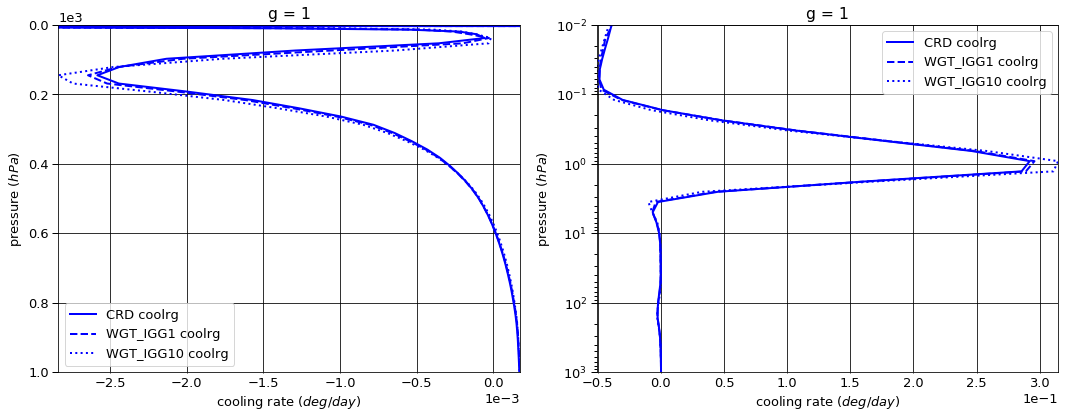

# Figure: cooling rate g-group 2

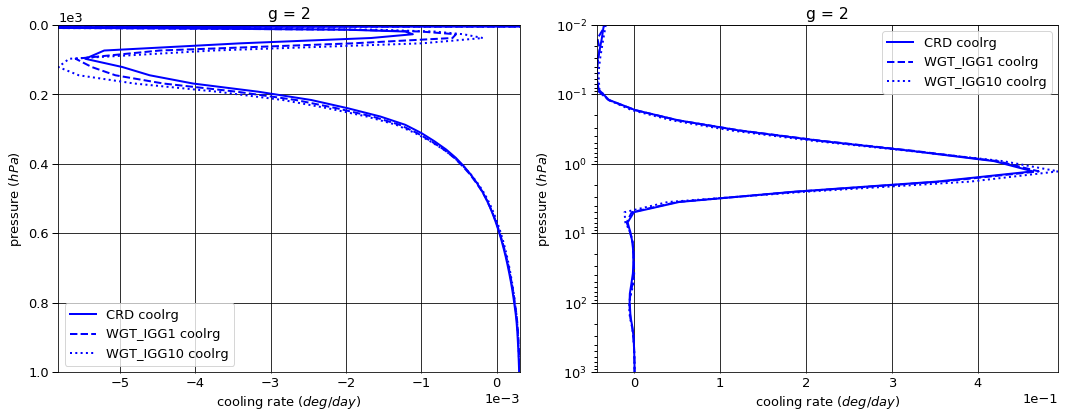

# Figure: cooling rate g-group 3

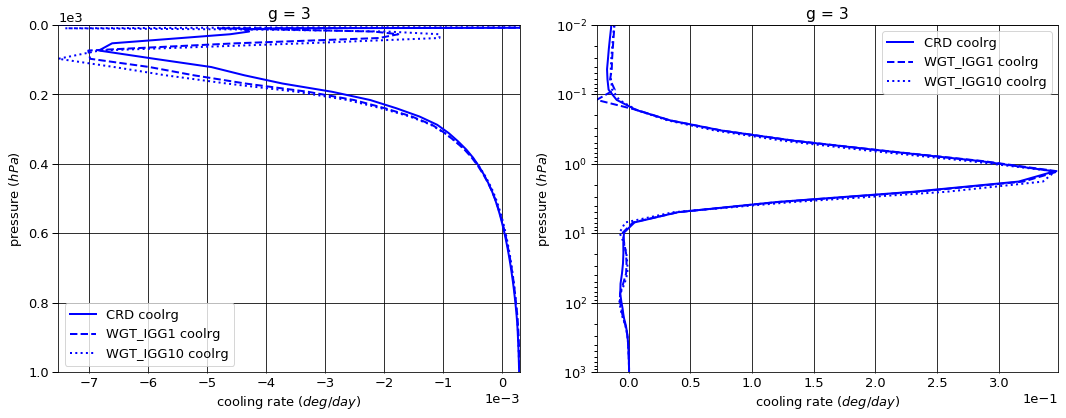

# Figure: cooling rate g-group 4

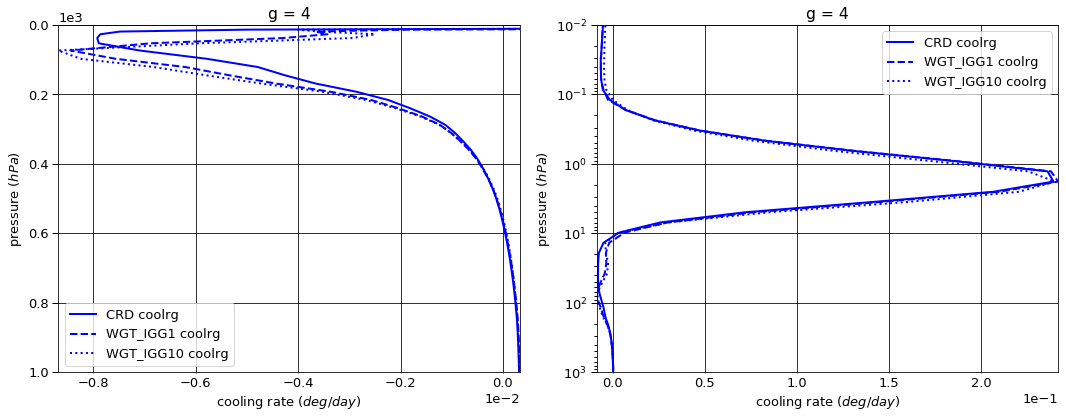

# Figure: cooling rate g-group 5

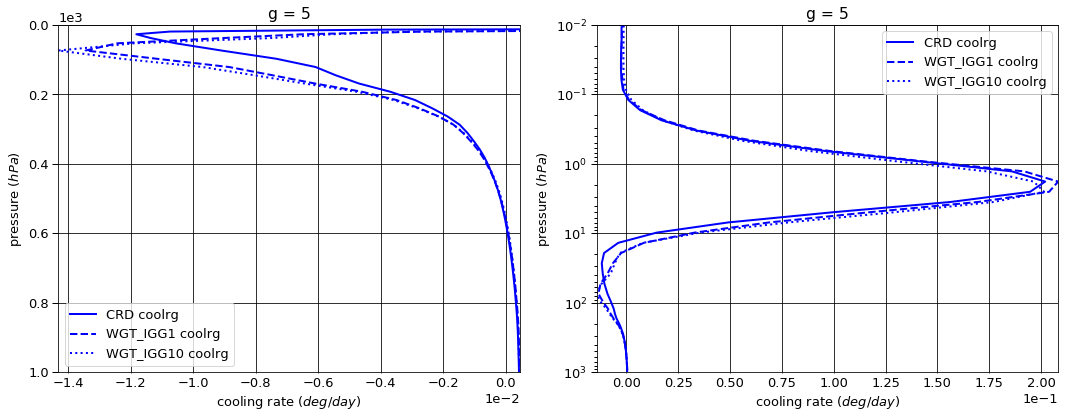

# Figure: cooling rate g-group 6

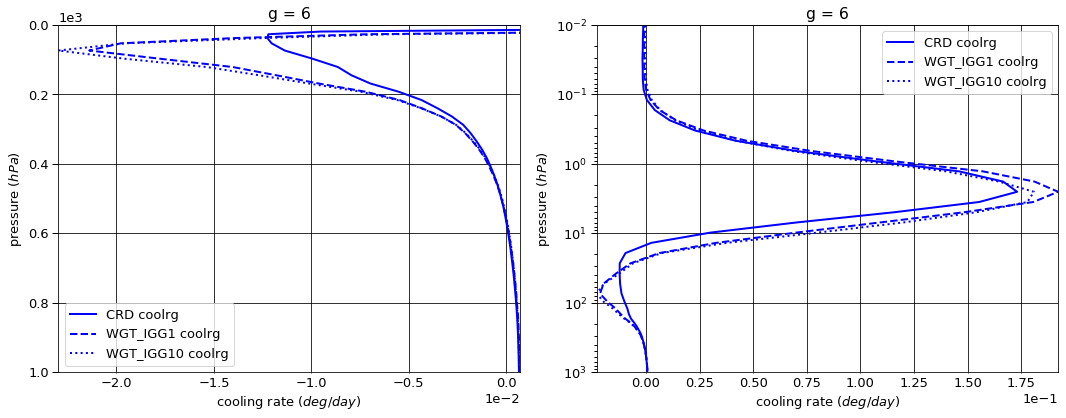

# Figure: cooling rate g-group 7

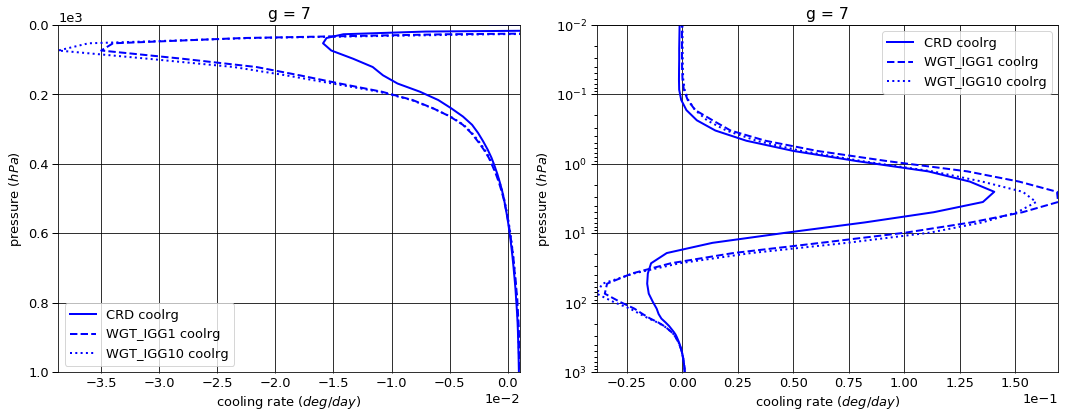

# Figure: cooling rate g-group 8

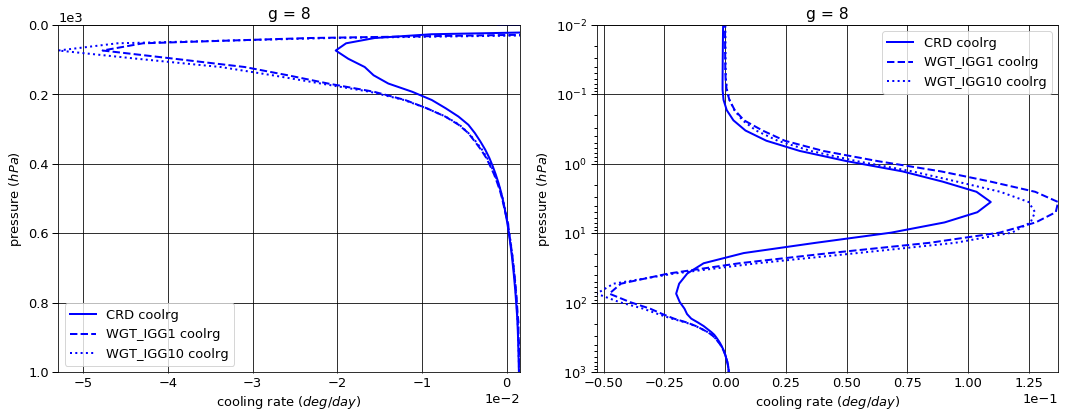

# Figure: cooling rate g-group 9

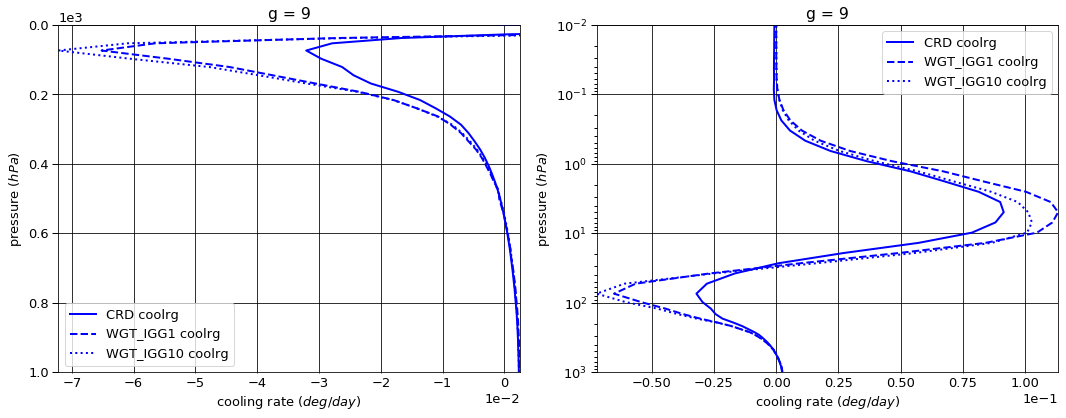

# Figure: cooling rate g-group 10

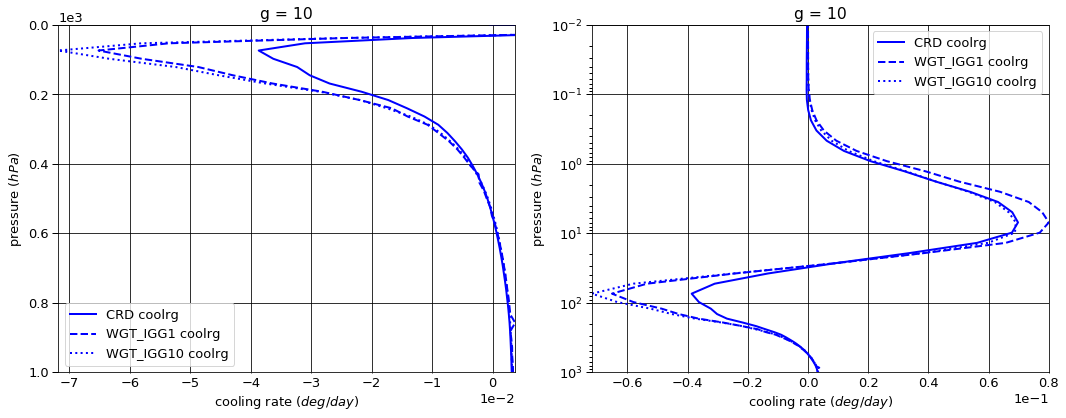

# Figure: cooling rate g-group 11

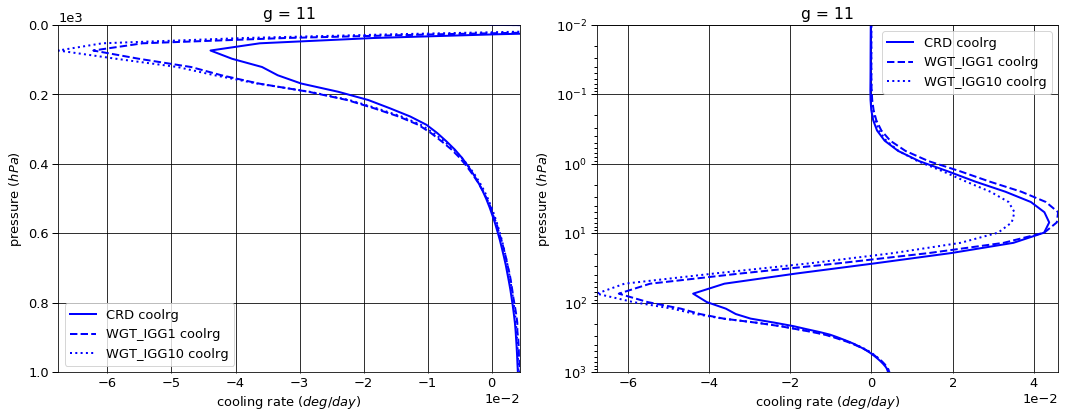

# Figure: cooling rate g-group 12

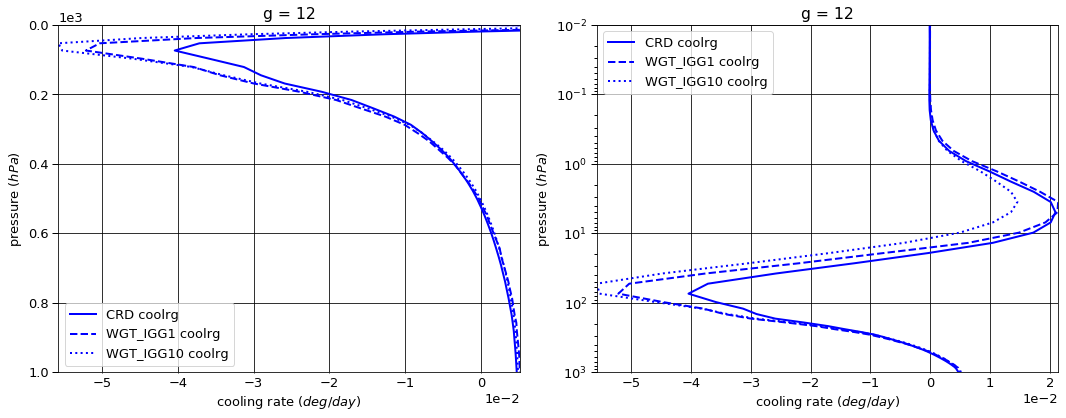

# Figure: cooling rate g-group 13

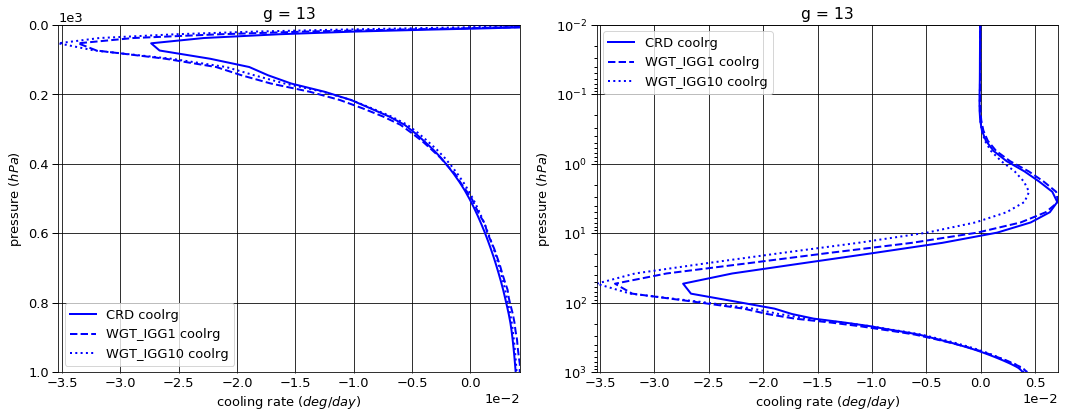

# Figure: cooling rate g-group 14

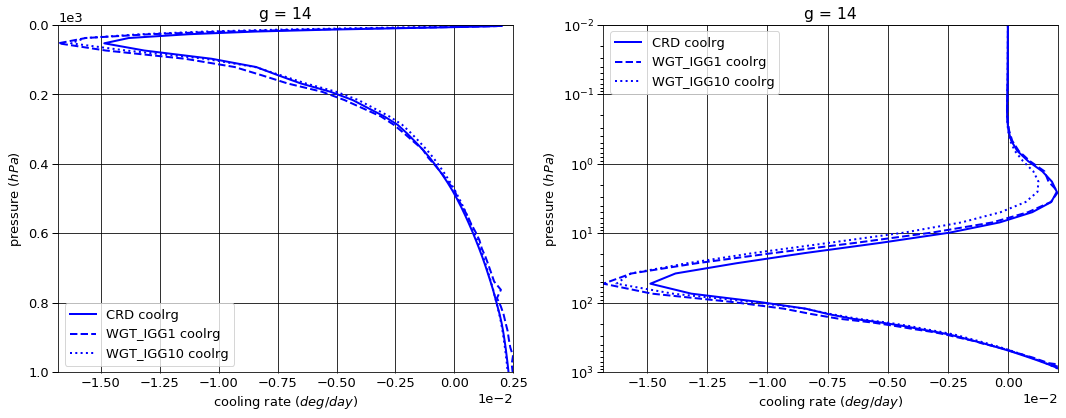

# Figure: cooling rate g-group 15

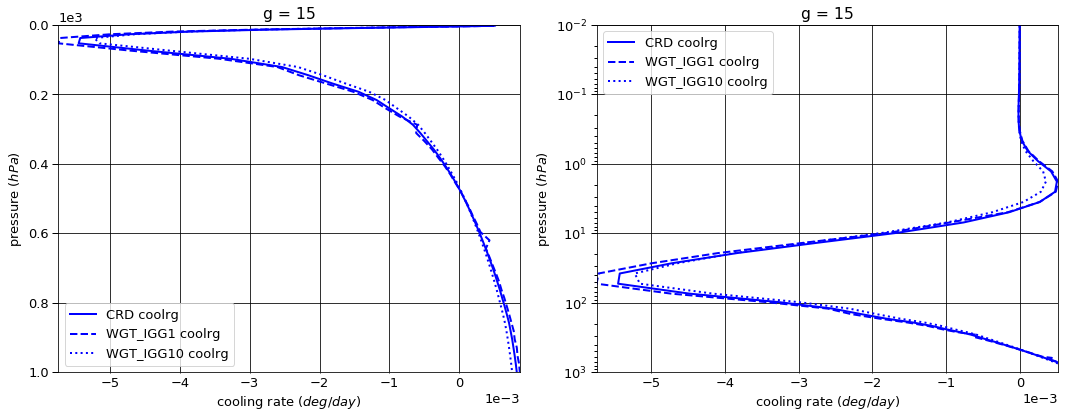

# Figure: cooling rate g-group 16

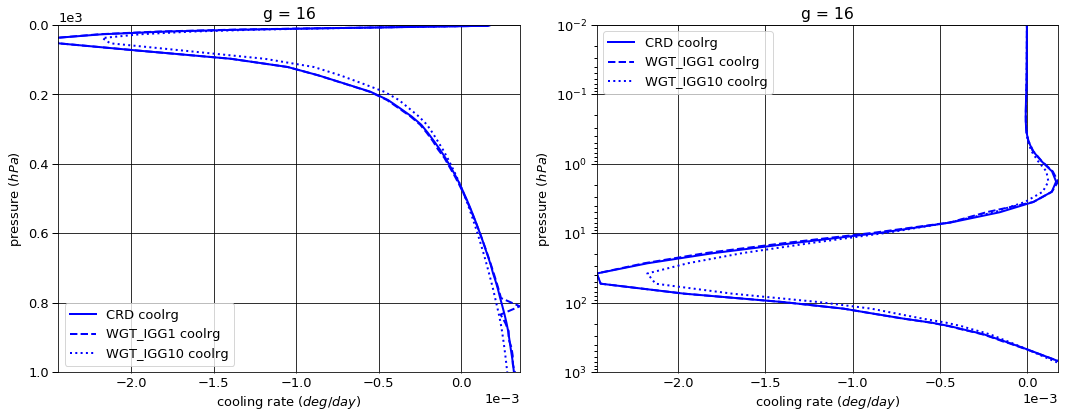

# Figure: cooling rate g-group 17

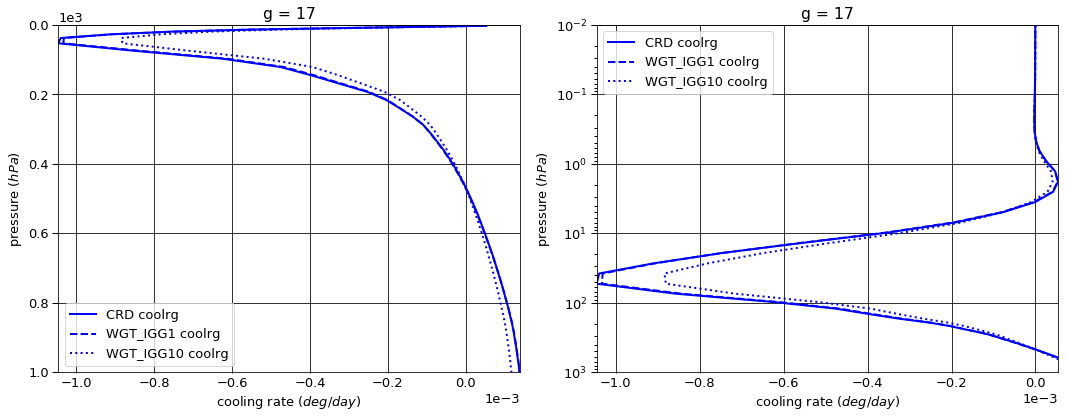

# Figure: cooling rate g-group 18

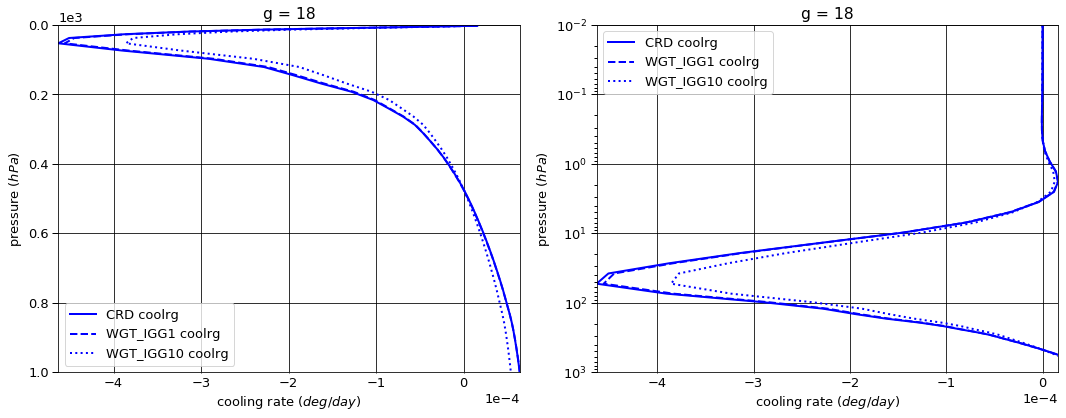

# Figure: cooling rate g-group 19

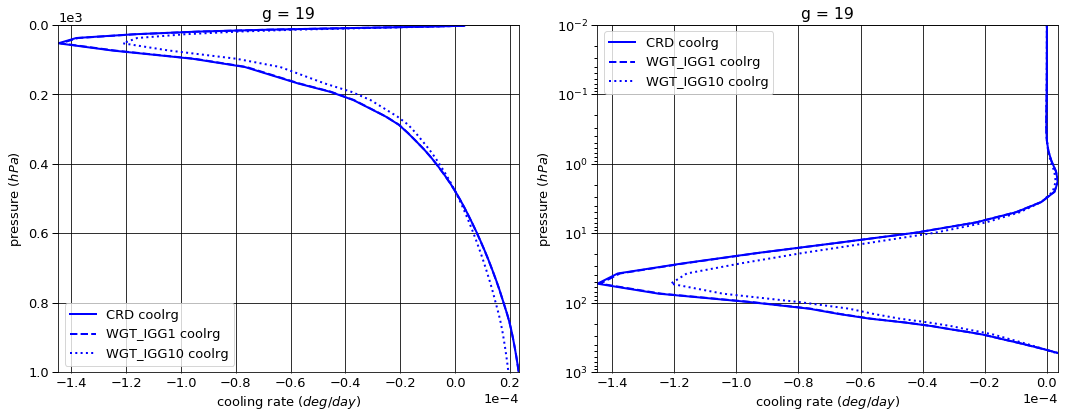

# Figure: cooling rate g-group 20

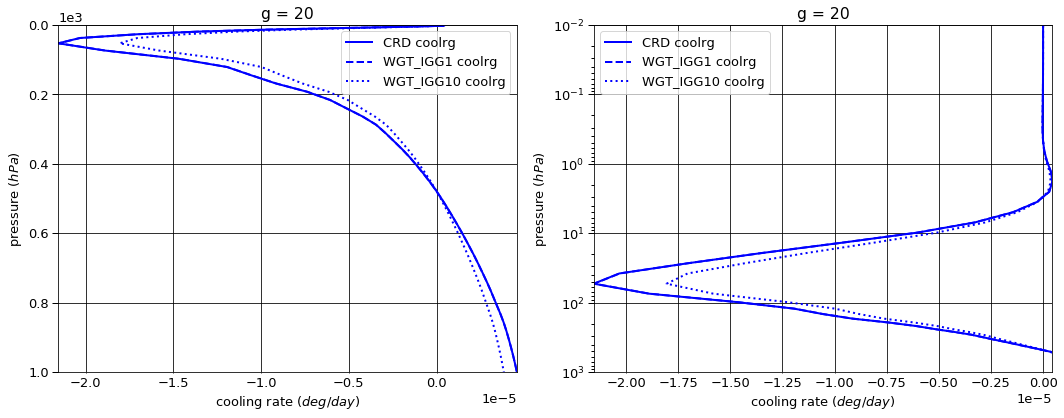

# Figure: cooling rate g-group total

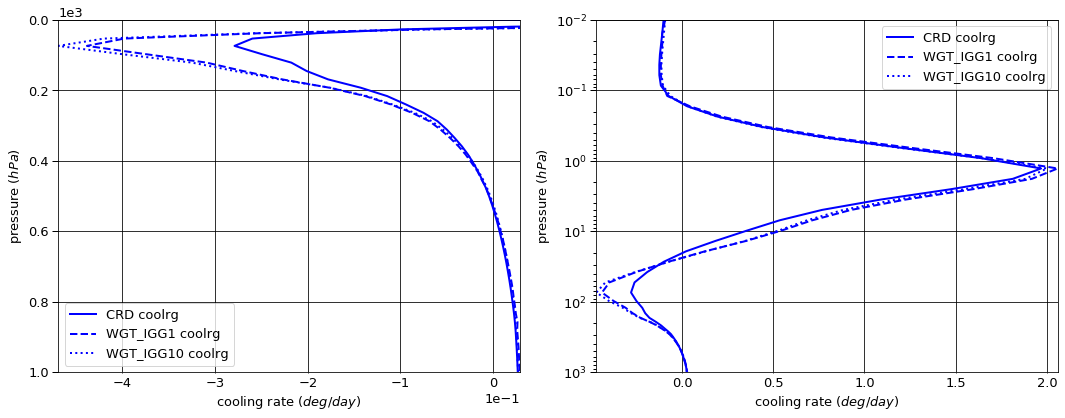

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.047585  0.000000 -0.047585
   1013.0   76    -0.086255  0.034408 -0.051847
2  0.0      1     -0.094793  0.000000 -0.094793
   1013.0   76    -0.168768  0.061270 -0.107498
3  0.0      1     -0.098238  0.000000 -0.098238
   1013.0   76    -0.186615  0.062660 -0.123954
4  0.0      1     -0.098165  0.000000 -0.098165
   1013.0   76    -0.207584  0.069455 -0.138129
5  0.0      1     -0.134542  0.000000 -0.134542
   1013.0   76    -0.309533  0.099085 -0.210448
6  0.0      1     -0.223348  0.000000 -0.223348
   1013.0   76    -0.493390  0.148087 -0.345303
7  0.0      1     -0.410927  0.000000 -0.410927
   1013.0   76    -0.816251  0.211951 -0.604300
8  0.0      1     -0.627561  0.000000 -0.627561
   1013.0   76    -1.196331  0.293259 -0.903072
9  0.0      1     -1.056704  0.000000 -1.056704
   1013.0   76    -1.960505  0.450238 -1.510268
10 0.0      1     -1.319560  0.000000 -1.319560
   1013.0   76    -2.483574  0.575323 -1.908251
11 0.0      1     -1.799417  0.000000 -1.799417
   1013.0   76    -3.221427  0.701887 -2.519540
12 0.0      1     -2.555735  0.000000 -2.555735
   1013.0   76    -3.961347  0.724632 -3.236715
13 0.0      1     -3.042477  0.000000 -3.042477
   1013.0   76    -3.987792  0.522183 -3.465609
14 0.0      1     -3.062151  0.000000 -3.062151
   1013.0   76    -3.517568  0.268215 -3.249353
15 0.0      1     -2.536656  0.000000 -2.536656
   1013.0   76    -2.682242  0.087754 -2.594488
16 0.0      1     -2.179423  0.000000 -2.179423
   1013.0   76    -2.238531  0.033605 -2.204926
17 0.0      1     -1.702931  0.000000 -1.702931
   1013.0   76    -1.728631  0.014398 -1.714233
18 0.0      1     -1.231632  0.000000 -1.231632
   1013.0   76    -1.243561  0.006635 -1.236925
19 0.0      1     -0.666917  0.000000 -0.666917
   1013.0   76    -0.670908  0.002308 -0.668600
20 0.0      1     -0.192789  0.000000 -0.192789
   1013.0   76    -0.193424  0.000405 -0.193019


WGT_IGG1


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.047657  0.000000 -0.047657
   1013.0   76    -0.086255  0.034778 -0.051477
2  0.0      1     -0.095203  0.000000 -0.095203
   1013.0   76    -0.168768  0.062218 -0.106550
3  0.0      1     -0.098888  0.000000 -0.098888
   1013.0   76    -0.186615  0.063129 -0.123486
4  0.0      1     -0.098350  0.000000 -0.098350
   1013.0   76    -0.207584  0.069166 -0.138418
5  0.0      1     -0.126151  0.000000 -0.126151
   1013.0   76    -0.309533  0.098665 -0.210868
6  0.0      1     -0.175258  0.000000 -0.175258
   1013.0   76    -0.493390  0.155040 -0.338350
7  0.0      1     -0.255948  0.000000 -0.255948
   1013.0   76    -0.816251  0.243572 -0.572679
8  0.0      1     -0.350650  0.000000 -0.350650
   1013.0   76    -1.196331  0.356458 -0.839873
9  0.0      1     -0.610112  0.000000 -0.610112
   1013.0   76    -1.960505  0.559966 -1.400540
10 0.0      1     -0.855642  0.000000 -0.855642
   1013.0   76    -2.483574  0.699770 -1.783803
11 0.0      1     -1.417483  0.000000 -1.417483
   1013.0   76    -3.221427  0.815465 -2.405961
12 0.0      1     -2.290151  0.000000 -2.290151
   1013.0   76    -3.961347  0.818922 -3.142425
13 0.0      1     -2.918479  0.000000 -2.918479
   1013.0   76    -3.987792  0.575128 -3.412663
14 0.0      1     -3.022813  0.000000 -3.022813
   1013.0   76    -3.517568  0.288566 -3.229002
15 0.0      1     -2.530255  0.000000 -2.530255
   1013.0   76    -2.682242  0.091276 -2.590967
16 0.0      1     -2.178786  0.000000 -2.178786
   1013.0   76    -2.238531  0.034166 -2.204365
17 0.0      1     -1.703030  0.000000 -1.703030
   1013.0   76    -1.728631  0.014467 -1.714164
18 0.0      1     -1.231736  0.000000 -1.231736
   1013.0   76    -1.243561  0.006645 -1.236916
19 0.0      1     -0.666930  0.000000 -0.666930
   1013.0   76    -0.670908  0.002309 -0.668599
20 0.0      1     -0.192789  0.000000 -0.192789
   1013.0   76    -0.193424  0.000405 -0.193019


WGT_IGG10


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.048502  0.000000 -0.048502
   1013.0   76    -0.086255  0.034269 -0.051986
2  0.0      1     -0.097006  0.000000 -0.097006
   1013.0   76    -0.168768  0.060874 -0.107894
3  0.0      1     -0.100355  0.000000 -0.100355
   1013.0   76    -0.186615  0.061373 -0.125241
4  0.0      1     -0.099249  0.000000 -0.099249
   1013.0   76    -0.207584  0.067087 -0.140497
5  0.0      1     -0.126629  0.000000 -0.126629
   1013.0   76    -0.309533  0.095251 -0.214282
6  0.0      1     -0.173930  0.000000 -0.173930
   1013.0   76    -0.493390  0.149858 -0.343532
7  0.0      1     -0.247046  0.000000 -0.247046
   1013.0   76    -0.816251  0.236011 -0.580240
8  0.0      1     -0.330313  0.000000 -0.330313
   1013.0   76    -1.196331  0.347265 -0.849066
9  0.0      1     -0.557837  0.000000 -0.557837
   1013.0   76    -1.960505  0.550477 -1.410028
10 0.0      1     -0.785553  0.000000 -0.785553
   1013.0   76    -2.483574  0.689406 -1.794167
11 0.0      1     -1.350613  0.000000 -1.350613
   1013.0   76    -3.221427  0.800915 -2.420512
12 0.0      1     -2.272763  0.000000 -2.272763
   1013.0   76    -3.961347  0.790645 -3.170701
13 0.0      1     -2.954678  0.000000 -2.954678
   1013.0   76    -3.987792  0.538151 -3.449641
14 0.0      1     -3.063566  0.000000 -3.063566
   1013.0   76    -3.517568  0.259827 -3.257741
15 0.0      1     -2.549218  0.000000 -2.549218
   1013.0   76    -2.682242  0.079200 -2.603042
16 0.0      1     -2.187421  0.000000 -2.187421
   1013.0   76    -2.238531  0.029035 -2.209496
17 0.0      1     -1.706983  0.000000 -1.706983
   1013.0   76    -1.728631  0.012203 -1.716428
18 0.0      1     -1.233613  0.000000 -1.233613
   1013.0   76    -1.243561  0.005581 -1.237979
19 0.0      1     -0.667572  0.000000 -0.667572
   1013.0   76    -0.670908  0.001935 -0.668974
20 0.0      1     -0.192893  0.000000 -0.192893
   1013.0   76    -0.193424  0.000339 -0.193085


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1     -7.144100e-05  0.000000e+00 -7.144100e-05
   1013.0   76     0.000000e+00  3.699550e-04  3.699550e-04
2  0.0      1     -4.098800e-04  0.000000e+00 -4.098800e-04
   1013.0   76     0.000000e+00  9.482510e-04  9.482500e-04
3  0.0      1     -6.503490e-04  0.000000e+00 -6.503490e-04
   1013.0   76     0.000000e+00  4.682900e-04  4.682900e-04
4  0.0      1     -1.849090e-04  0.000000e+00 -1.849090e-04
   1013.0   76     0.000000e+00 -2.886210e-04 -2.886200e-04
5  0.0      1      8.390990e-03  0.000000e+00  8.390990e-03
   1013.0   76     0.000000e+00 -4.202380e-04 -4.202400e-04
6  0.0      1      4.809001e-02  0.000000e+00  4.809001e-02
   1013.0   76     0.000000e+00  6.952830e-03  6.952820e-03
7  0.0      1      1.549791e-01  0.000000e+00  1.549791e-01
   1013.0   76     0.000000e+00  3.162110e-02  3.162110e-02
8  0.0      1      2.769109e-01  0.000000e+00  2.769109e-01
   1013.0   76     0.000000e+00  6.319946e-02  6.319946e-02
9  0.0      1      4.465927e-01  0.000000e+00  4.465927e-01
   1013.0   76     0.000000e+00  1.097281e-01  1.097281e-01
10 0.0      1      4.639178e-01  0.000000e+00  4.639178e-01
   1013.0   76     0.000000e+00  1.244475e-01  1.244475e-01
11 0.0      1      3.819337e-01  0.000000e+00  3.819337e-01
   1013.0   76     0.000000e+00  1.135786e-01  1.135786e-01
12 0.0      1      2.655841e-01  0.000000e+00  2.655841e-01
   1013.0   76     4.440892e-16  9.429029e-02  9.429030e-02
13 0.0      1      1.239976e-01  0.000000e+00  1.239976e-01
   1013.0   76    -4.440892e-16  5.294581e-02  5.294580e-02
14 0.0      1      3.933770e-02  0.000000e+00  3.933770e-02
   1013.0   76    -4.440892e-16  2.035091e-02  2.035090e-02
15 0.0      1      6.401200e-03  0.000000e+00  6.401200e-03
   1013.0   76     0.000000e+00  3.521774e-03  3.521800e-03
16 0.0      1      6.364000e-04  0.000000e+00  6.364000e-04
   1013.0   76     0.000000e+00  5.609950e-04  5.610000e-04
17 0.0      1     -9.840000e-05  0.000000e+00 -9.840000e-05
   1013.0   76     2.220446e-16  6.876700e-05  6.880000e-05
18 0.0      1     -1.038000e-04  0.000000e+00 -1.038000e-04
   1013.0   76     0.000000e+00  9.531700e-06  9.500000e-06
19 0.0      1     -1.271000e-05  0.000000e+00 -1.271000e-05
   1013.0   76     0.000000e+00  1.027100e-06  1.030000e-06
20 0.0      1     -7.000000e-08  0.000000e+00 -7.000000e-08
   1013.0   76     0.000000e+00  5.315000e-08  6.000000e-08


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                                  
1  0.0      1     -9.171360e-04  0.000000 -0.000917
   1013.0   76     0.000000e+00 -0.000139 -0.000139
2  0.0      1     -2.212387e-03  0.000000 -0.002212
   1013.0   76     0.000000e+00 -0.000396 -0.000396
3  0.0      1     -2.116627e-03  0.000000 -0.002117
   1013.0   76     0.000000e+00 -0.001287 -0.001287
4  0.0      1     -1.083507e-03  0.000000 -0.001084
   1013.0   76     0.000000e+00 -0.002368 -0.002368
5  0.0      1      7.913010e-03  0.000000  0.007913
   1013.0   76     0.000000e+00 -0.003834 -0.003834
6  0.0      1      4.941781e-02  0.000000  0.049418
   1013.0   76     0.000000e+00  0.001771  0.001771
7  0.0      1      1.638807e-01  0.000000  0.163881
   1013.0   76     0.000000e+00  0.024060  0.024060
8  0.0      1      2.972488e-01  0.000000  0.297249
   1013.0   76     0.000000e+00  0.054006  0.054006
9  0.0      1      4.988673e-01  0.000000  0.498867
   1013.0   76     0.000000e+00  0.100240  0.100240
10 0.0      1      5.340076e-01  0.000000  0.534008
   1013.0   76     0.000000e+00  0.114083  0.114083
11 0.0      1      4.488031e-01  0.000000  0.448803
   1013.0   76     0.000000e+00  0.099028  0.099028
12 0.0      1      2.829716e-01  0.000000  0.282972
   1013.0   76     4.440892e-16  0.066014  0.066014
13 0.0      1      8.779820e-02  0.000000  0.087798
   1013.0   76    -4.440892e-16  0.015968  0.015968
14 0.0      1     -1.414900e-03  0.000000 -0.001415
   1013.0   76    -4.440892e-16 -0.008388 -0.008388
15 0.0      1     -1.256140e-02  0.000000 -0.012561
   1013.0   76     0.000000e+00 -0.008554 -0.008554
16 0.0      1     -7.997900e-03  0.000000 -0.007998
   1013.0   76     0.000000e+00 -0.004570 -0.004570
17 0.0      1     -4.052200e-03  0.000000 -0.004052
   1013.0   76     2.220446e-16 -0.002196 -0.002196
18 0.0      1     -1.980300e-03  0.000000 -0.001980
   1013.0   76     0.000000e+00 -0.001054 -0.001054
19 0.0      1     -6.549900e-04  0.000000 -0.000655
   1013.0   76     0.000000e+00 -0.000374 -0.000374
20 0.0      1     -1.039400e-04  0.000000 -0.000104
   1013.0   76     0.000000e+00 -0.000066 -0.000066

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.555016e-02
   1001.112500 75     1.694643e-04
2  0.000312    1     -2.010693e-02
   1001.112500 75     3.003306e-04
3  0.000312    1     -5.307366e-03
   1001.112500 75     2.915039e-04
4  0.000312    1     -2.027760e-03
   1001.112500 75     3.166016e-04
5  0.000312    1     -8.669429e-04
   1001.112500 75     4.258918e-04
6  0.000312    1     -5.027916e-04
   1001.112500 75     6.541184e-04
7  0.000312    1     -4.689487e-04
   1001.112500 75     9.607087e-04
8  0.000312    1     -2.990309e-04
   1001.112500 75     1.464135e-03
9  0.000312    1     -2.525654e-04
   1001.112500 75     2.359362e-03
10 0.000312    1     -1.198017e-04
   1001.112500 75     3.156396e-03
11 0.000312    1     -6.230462e-05
   1001.112500 75     4.097111e-03
12 0.000312    1     -3.052526e-05
   1001.112500 75     4.692618e-03
13 0.000312    1     -1.464262e-05
   1001.112500 75     3.891550e-03
14 0.000312    1     -5.290341e-06
   1001.112500 75     2.298270e-03
15 0.000312    1     -2.119535e-06
   1001.112500 75     8.221554e-04
16 0.000312    1     -8.104962e-07
   1001.112500 75     3.184392e-04
17 0.000312    1     -1.477303e-07
   1001.112500 75     1.375437e-04
18 0.000312    1     -1.868769e-08
   1001.112500 75     6.409194e-05
19 0.000312    1     -9.141206e-10
   1001.112500 75     2.325188e-05
20 0.000312    1     -2.701834e-11
   1001.112500 75     4.575945e-06


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1     -1.567554e-02
   1001.112500 75     1.727324e-04
2  0.000312    1     -1.354034e-02
   1001.112500 75     3.090628e-04
3  0.000312    1     -4.527912e-03
   1001.112500 75     3.028063e-04
4  0.000312    1     -2.043684e-03
   1001.112500 75     3.312200e-04
5  0.000312    1     -8.241895e-04
   1001.112500 75     4.523800e-04
6  0.000312    1     -3.297137e-04
   1001.112500 75     6.959863e-04
7  0.000312    1     -1.499061e-04
   1001.112500 75     1.040097e-03
8  0.000312    1     -5.368727e-05
   1001.112500 75     1.573181e-03
9  0.000312    1     -3.300042e-05
   1001.112500 75     2.515005e-03
10 0.000312    1     -1.776444e-05
   1001.112500 75     3.371364e-03
11 0.000312    1     -1.833666e-05
   1001.112500 75     4.404153e-03
12 0.000312    1     -1.420355e-05
   1001.112500 75     5.097407e-03
13 0.000312    1     -9.094506e-06
   1001.112500 75     4.238851e-03
14 0.000312    1     -3.992542e-06
   1001.112500 75     2.474489e-03
15 0.000312    1     -1.772271e-06
   1001.112500 75     8.654849e-04
16 0.000312    1     -7.131521e-07
   1001.112500 75     3.246821e-04
17 0.000312    1     -1.355660e-07
   1001.112500 75     1.387200e-04
18 0.000312    1     -1.775105e-08
   1001.112500 75     6.423469e-05
19 0.000312    1     -9.066155e-10
   1001.112500 75     2.326559e-05
20 0.000312    1     -2.851936e-11
   1001.112500 75     4.576659e-06


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1     -1.596066e-02
   1001.112500 75     1.710007e-04
2  0.000312    1     -1.262207e-02
   1001.112500 75     3.024664e-04
3  0.000312    1     -4.517375e-03
   1001.112500 75     2.925304e-04
4  0.000312    1     -1.547554e-03
   1001.112500 75     3.201301e-04
5  0.000312    1     -5.424738e-04
   1001.112500 75     4.328004e-04
6  0.000312    1     -1.848998e-04
   1001.112500 75     6.665711e-04
7  0.000312    1     -5.875591e-05
   1001.112500 75     9.877848e-04
8  0.000312    1     -1.106933e-05
   1001.112500 75     1.479496e-03
9  0.000312    1     -1.278998e-05
   1001.112500 75     2.376054e-03
10 0.000312    1     -1.475338e-05
   1001.112500 75     3.217073e-03
11 0.000312    1     -1.993718e-05
   1001.112500 75     4.191313e-03
12 0.000312    1     -1.632236e-05
   1001.112500 75     4.860996e-03
13 0.000312    1     -9.935154e-06
   1001.112500 75     3.971265e-03
14 0.000312    1     -4.015526e-06
   1001.112500 75     2.263317e-03
15 0.000312    1     -1.649278e-06
   1001.112500 75     7.559236e-04
16 0.000312    1     -6.340964e-07
   1001.112500 75     2.778793e-04
17 0.000312    1     -1.164461e-07
   1001.112500 75     1.171172e-04
18 0.000312    1     -1.506423e-08
   1001.112500 75     5.399073e-05
19 0.000312    1     -7.655197e-10
   1001.112500 75     1.950174e-05
20 0.000312    1     -2.364105e-11
   1001.112500 75     3.828915e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.253730e-04
   1001.112500 75     3.268060e-06
2  0.000312    1      6.566585e-03
   1001.112500 75     8.732260e-06
3  0.000312    1      7.794539e-04
   1001.112500 75     1.130242e-05
4  0.000312    1     -1.592420e-05
   1001.112500 75     1.461839e-05
5  0.000312    1      4.275334e-05
   1001.112500 75     2.648819e-05
6  0.000312    1      1.730779e-04
   1001.112500 75     4.186796e-05
7  0.000312    1      3.190426e-04
   1001.112500 75     7.938792e-05
8  0.000312    1      2.453436e-04
   1001.112500 75     1.090463e-04
9  0.000312    1      2.195650e-04
   1001.112500 75     1.556439e-04
10 0.000312    1      1.020373e-04
   1001.112500 75     2.149677e-04
11 0.000312    1      4.396796e-05
   1001.112500 75     3.070421e-04
12 0.000312    1      1.632170e-05
   1001.112500 75     4.047891e-04
13 0.000312    1      5.548114e-06
   1001.112500 75     3.473008e-04
14 0.000312    1      1.297799e-06
   1001.112500 75     1.762181e-04
15 0.000312    1      3.472637e-07
   1001.112500 75     4.332952e-05
16 0.000312    1      9.734408e-08
   1001.112500 75     6.242820e-06
17 0.000312    1      1.216426e-08
   1001.112500 75     1.176370e-06
18 0.000312    1      9.366360e-10
   1001.112500 75     1.427510e-07
19 0.000312    1      7.505100e-12
   1001.112500 75     1.371100e-08
20 0.000312    1     -1.501019e-12
   1001.112500 75     7.140000e-10


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -4.104980e-04
   1001.112500 75     1.536370e-06
2  0.000312    1      7.484863e-03
   1001.112500 75     2.135840e-06
3  0.000312    1      7.899906e-04
   1001.112500 75     1.026530e-06
4  0.000312    1      4.802066e-04
   1001.112500 75     3.528450e-06
5  0.000312    1      3.244690e-04
   1001.112500 75     6.908610e-06
6  0.000312    1      3.178919e-04
   1001.112500 75     1.245276e-05
7  0.000312    1      4.101928e-04
   1001.112500 75     2.707609e-05
8  0.000312    1      2.879616e-04
   1001.112500 75     1.536160e-05
9  0.000312    1      2.397754e-04
   1001.112500 75     1.669210e-05
10 0.000312    1      1.050483e-04
   1001.112500 75     6.067690e-05
11 0.000312    1      4.236744e-05
   1001.112500 75     9.420200e-05
12 0.000312    1      1.420289e-05
   1001.112500 75     1.683782e-04
13 0.000312    1      4.707466e-06
   1001.112500 75     7.971510e-05
14 0.000312    1      1.274815e-06
   1001.112500 75    -3.495320e-05
15 0.000312    1      4.702572e-07
   1001.112500 75    -6.623175e-05
16 0.000312    1      1.763997e-07
   1001.112500 75    -4.056000e-05
17 0.000312    1      3.128424e-08
   1001.112500 75    -2.042645e-05
18 0.000312    1      3.623460e-09
   1001.112500 75    -1.010121e-05
19 0.000312    1      1.486009e-10
   1001.112500 75    -3.750138e-06
20 0.000312    1      3.377292e-12
   1001.112500 75    -7.470306e-07

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.081552,0.000000,-23.081552
1013.0,76,-31.354237,4.367759,-26.986478



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.866311,0.000000,-20.866311
1013.0,76,-31.354237,4.990113,-26.364124



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.745739,0.000000,-20.745739
1013.0,76,-31.354237,4.809704,-26.544533



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.215241,0.000000,2.215241
1013.0,76,0.000000,0.622354,0.622354



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.335813,0.000000,2.335813
1013.0,76,0.000000,0.441945,0.441945


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.045618
1001.112500,75,0.026448



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.037244
1001.112500,75,0.028400



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.035525
1001.112500,75,0.026761



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.008374
1001.112500,75,0.001952



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.010093
1001.112500,75,0.000313


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.002750,0.002746
2,0.005375,0.005377
3,0.005917,0.005958
4,0.006583,0.006627
5,0.009792,0.009893
6,0.015583,0.015781
7,0.025917,0.026062
8,0.037792,0.038271
9,0.061625,0.062849


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.033647e-17
2,4.613440e-18
3,2.059101e-18
4,9.190315e-19
5,4.101882e-19
6,1.830779e-19
7,8.171255e-20
8,3.647049e-20
9,1.627775e-20


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.033647e-17,NaN,0.002750,0.002746,0.002750,0.002746,1.0
2,4.613440e-18,0.446327,0.005375,0.005377,0.008125,0.008123,1.0
3,2.059101e-18,0.446327,0.005917,0.005958,0.014042,0.014081,1.0
4,9.190315e-19,0.446327,0.006583,0.006627,0.020625,0.020708,1.0
5,4.101882e-19,0.446327,0.009792,0.009893,0.030417,0.030601,1.0
6,1.830779e-19,0.446327,0.015583,0.015781,0.046000,0.046383,1.0
7,8.171255e-20,0.446327,0.025917,0.026062,0.071917,0.072444,1.0
8,3.647049e-20,0.446327,0.037792,0.038271,0.109708,0.110715,1.0
9,1.627775e-20,0.446327,0.061625,0.062849,0.171333,0.173564,1.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     1.904510e-17  1.771612e-17   1.075015  2.728740e-05
      2  0.000312     7.400987e-18  6.936080e-18   1.067027  1.060397e-05
      3  0.000312     2.727413e-18  2.519896e-18   1.082351  3.907777e-06
      4  0.000312     1.071395e-18  9.738452e-19   1.100169  1.535070e-06
      5  0.000312     3.715372e-19  3.360308e-19   1.105664  5.323302e-07
      6  0.000312     1.300613e-19  1.145529e-19   1.135383  1.863490e-07
      7  0.000312     5.485491e-20  4.625539e-20   1.185914  7.859490e-08
      8  0.000312     2.207780e-20  1.777691e-20   1.241937  3.163258e-08
      9  0.000312     1.003210e-20  7.623196e-21   1.315997  1.437377e-08
      10 0.000312     3.540592e-21  2.700317e-21   1.311176  5.072881e-09
      11 0.000312     1.240318e-21  9.363685e-22   1.324604  1.777100e-09
      12 0.000312     4.136514e-22  3.203477e-22   1.291258  5.926706e-10
      13 0.000312     1.624555e-22  1.247702e-22   1.302038  2.327627e-10
      14 0.000312     5.843228e-23  4.587771e-23   1.273653  8.372047e-11
      15 0.000312     2.778214e-23  2.118523e-23   1.311392  3.980563e-11
      16 0.000312     1.225209e-23  8.843885e-24   1.385374  1.755451e-11
      17 0.000312     2.860854e-24  2.247902e-24   1.272678  4.098968e-12
      18 0.000312     5.060626e-25  4.318903e-25   1.171739  7.250752e-13
      19 0.000312     4.695747e-26  4.378122e-26   1.072548  6.727962e-14
      20 0.000312     4.988906e-27  4.874085e-27   1.023558  7.147993e-15
2     1  0.000750     1.902529e-17  1.770298e-17   1.074694  1.231451e-05
      2  0.000750     7.401325e-18  6.937993e-18   1.066782  4.790658e-06
      3  0.000750     2.730041e-18  2.523290e-18   1.081937  1.767075e-06
      4  0.000750     1.073425e-18  9.760605e-19   1.099753  6.947964e-07
      5  0.000750     3.726052e-19  3.371285e-19   1.105232  2.411763e-07
      6  0.000750     1.305824e-19  1.150321e-19   1.135182  8.452214e-08
      7  0.000750     5.507184e-20  4.645704e-20   1.185436  3.564637e-08
      8  0.000750     2.215820e-20  1.785525e-20   1.240991  1.434234e-08
      9  0.000750     1.006191e-20  7.654488e-21   1.314511  6.512773e-09
      10 0.000750     3.553052e-21  2.712538e-21   1.309863  2.299785e-09
      11 0.000750     1.245395e-21  9.412419e-22   1.323141  8.061075e-10
      12 0.000750     4.157879e-22  3.223192e-22   1.289988  2.691272e-10
      13 0.000750     1.633730e-22  1.256073e-22   1.300665  1.057465e-10
      14 0.000750     5.882351e-23  4.623125e-23   1.272375  3.807471e-11
      15 0.000750     2.794414e-23  2.133500e-23   1.309779  1.808741e-11
      16 0.000750     1.231639e-23  8.904026e-24   1.383238  7.972031e-12
      17 0.000750     2.886675e-24  2.271345e-24   1.270910  1.868459e-12
      18 0.000750     5.154127e-25  4.406981e-25   1.169537  3.336113e-13
      19 0.000750     5.048744e-26  4.727570e-26   1.067936  3.267903e-14
      20 0.000750     6.587128e-27  6.470196e-27   1.018072  4.263653e-15
3     1  0.001052     1.898425e-17  1.767578e-17   1.074026  2.095998e-05
      2  0.001052     7.402188e-18  6.942110e-18   1.066273  8.172551e-06
      3  0.001052     2.735570e-18  2.530400e-18   1.081082  3.020268e-06
      4  0.001052     1.077674e-18  9.806624e-19   1.098924  1.189830e-06
      5  0.001052     3.748225e-19  3.393867e-19   1.104411  4.138311e-07
      6  0.001052     1.316557e-19  1.159975e-19   1.134987  1.453574e-07
      7  0.001052     5.551672e-20  4.685898e-20   1.184762  6.129447e-08
      8  0.001052     2.231911e-20  1.800633e-20   1.239514  2.464191e-08
      9  0.001052     1.012042e-20  7.713658e-21   1.312014  1.117368e-08
      10 0.001052     3.576552e-21  2.734566e-21   1.307905  3.948773e-09
      11 0.001052     1.254636e-21  9.497165e-22   1.321064  1.385209e-09
      12 0.001052     4.195764e-22  3.256479e-22   1.288436  4.632427e-10
      13 0.001052     1.649801e

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
